# Cart Pole with neural function approximator TF2
### Christian Igel, 2019

If you have suggestions for improvement, [let me know](mailto:igel@diku.dk).

I took inspiration from https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb.

In [1]:
import gym

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
action_size = 2
state_size = 4

Let's just test the environment first:

In [3]:
test_episodes = 10
for _ in range(test_episodes):
    R = 0
    state = env.reset()  # Environment starts in a random state, cart and pole are moving
    print("initial state:", state)
    while True:  # Environment sets "done" to true after 200 steps 
        # Uncomment the line below to watch the simulation
        # env.render()
        state, reward, done, info = env.step(env.action_space.sample()) # take a random action
        R += reward
        if done:
            print("return: ", R)
            env.reset()
            break

initial state: [ 0.04955984 -0.00537115 -0.00052219 -0.04178765]
return:  10.0
initial state: [-0.02170706  0.0149275   0.02481736 -0.01341253]
return:  16.0
initial state: [ 0.0451842  -0.00534536 -0.02612767  0.00211796]
return:  41.0
initial state: [-0.01677121 -0.02224579 -0.0065124   0.00643503]
return:  20.0
initial state: [ 0.02683571 -0.04734673  0.03977117  0.02596666]
return:  26.0
initial state: [ 0.03973656  0.00048963  0.0226608  -0.02144592]
return:  60.0
initial state: [-0.03065499 -0.03581875  0.03972057  0.0334654 ]
return:  13.0
initial state: [ 0.02185343  0.03852237 -0.03194285 -0.02407094]
return:  24.0
initial state: [-0.01823235 -0.03445122  0.01056239  0.01591504]
return:  15.0
initial state: [-0.0050449  -0.03697841 -0.0061942  -0.04961251]
return:  33.0


In [4]:
env.close()  # Closes the visualization window

Define *Q* network architecture:

In [5]:
class QNetwork(tf.keras.Model):
    def __init__(self, state_size=4, action_size=2, hidden_size=10, name='QNetwork'):
        super(QNetwork, self).__init__()
        self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=True)
        self.fc2 = tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=True)
        self.fc3 = tf.keras.layers.Dense(action_size, activation=None, use_bias=True)
    def call(self, x):
        return self.fc3(self.fc2(self.fc1(x)))

Data structure for storing experiences:

In [6]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Define basic constants:

In [7]:
train_episodes = 400           # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.005           # minimum exploration probability 
decay_rate = 0.001             # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 100               # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

Instantiate network:

In [8]:
mainQN = QNetwork(name='main', hidden_size=hidden_size)
mainQN.build(input_shape=(None, state_size))
print(mainQN.summary())

Model: "q_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  320       
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  130       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________
None


Do the *Q*-learning:

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails, so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [10]:
learning_rate = 0.0001         # Q-network learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=0.01)

@tf.function
def compute_gradient(states, actions, targets, action_size=2):
    one_hot_actions = tf.one_hot(actions, action_size)
    with tf.GradientTape() as tape:
        output = mainQN(states)
        Q = tf.reduce_sum(tf.multiply(output, one_hot_actions), axis=1)
        loss = tf.math.reduce_mean(tf.square(Q - targets))
    return loss, tape.gradient(loss, mainQN.trainable_variables)

Now train with experiences:

In [11]:
rewards_list = []

step = 0
for ep in range(train_episodes):
    total_reward = 0
    t = 0
    state = env.reset()  # Reset and get initial state
    while t < max_steps:
        step += 1
        # Uncomment this next line to watch the training
        # env.render() 
            
        # Explore or exploit
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            Qs = mainQN(np.resize(state, (1, state_size)).astype(np.float32))
            action = np.argmax(Qs)
            
        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)
    
        total_reward += reward
           
        if done:
            # Episode ends, so no next state
            next_state = np.zeros(state.shape)
            t = max_steps
                
            print('Episode: {}'.format(ep), 'Total reward: {}'.format(total_reward),
                  'Training loss: {:.4f}'.format(loss), 'Explore P: {:.4f}'.format(explore_p))
            rewards_list.append((ep, total_reward))
                
            # Add experience to memory
            memory.add((state, action, reward, next_state))
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state
            t += 1
            
        # Sample mini-batch from memory
        batch = memory.sample(batch_size)
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        next_states = np.array([each[3] for each in batch])
            
        # Train network           
        target_Qs = mainQN(next_states.astype(np.float32)).numpy()
            
        # Set target_Qs to 0 for states where episode ends
        episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
        target_Qs[episode_ends] = (0., 0.)
            
        # Compute target Q values   
        targets = rewards + gamma * np.max(target_Qs, axis=1)  # Max: Q-learning is off-policy & greedy 

        # Gradient-based update
        loss, gradients = compute_gradient(states.astype(np.float32), actions, targets.astype(np.float32))
        optimizer.apply_gradients(zip(gradients, mainQN.trainable_variables))

log_path = "/tmp/deep_Q_network"
mainQN.save_weights(log_path)

Episode: 0 Total reward: 36.0 Training loss: 1.0270 Explore P: 0.9648
Episode: 1 Total reward: 34.0 Training loss: 1.0229 Explore P: 0.9327
Episode: 2 Total reward: 13.0 Training loss: 1.0345 Explore P: 0.9207
Episode: 3 Total reward: 16.0 Training loss: 1.0205 Explore P: 0.9062
Episode: 4 Total reward: 13.0 Training loss: 1.0343 Explore P: 0.8946
Episode: 5 Total reward: 17.0 Training loss: 1.0120 Explore P: 0.8796
Episode: 6 Total reward: 41.0 Training loss: 1.0462 Explore P: 0.8444
Episode: 7 Total reward: 22.0 Training loss: 1.0622 Explore P: 0.8262
Episode: 8 Total reward: 20.0 Training loss: 1.0862 Explore P: 0.8099
Episode: 9 Total reward: 24.0 Training loss: 0.9847 Explore P: 0.7908
Episode: 10 Total reward: 14.0 Training loss: 1.0369 Explore P: 0.7799
Episode: 11 Total reward: 21.0 Training loss: 1.0572 Explore P: 0.7638
Episode: 12 Total reward: 11.0 Training loss: 1.1239 Explore P: 0.7555
Episode: 13 Total reward: 18.0 Training loss: 1.1293 Explore P: 0.7421
Episode: 14 Tota

Episode: 117 Total reward: 10.0 Training loss: 9.9776 Explore P: 0.2284
Episode: 118 Total reward: 11.0 Training loss: 12.1248 Explore P: 0.2259
Episode: 119 Total reward: 11.0 Training loss: 17.2409 Explore P: 0.2235
Episode: 120 Total reward: 10.0 Training loss: 17.6079 Explore P: 0.2213
Episode: 121 Total reward: 12.0 Training loss: 19.4594 Explore P: 0.2187
Episode: 122 Total reward: 13.0 Training loss: 19.2509 Explore P: 0.2160
Episode: 123 Total reward: 9.0 Training loss: 13.0848 Explore P: 0.2141
Episode: 124 Total reward: 9.0 Training loss: 15.2715 Explore P: 0.2122
Episode: 125 Total reward: 10.0 Training loss: 19.9212 Explore P: 0.2102
Episode: 126 Total reward: 10.0 Training loss: 22.8229 Explore P: 0.2081
Episode: 127 Total reward: 14.0 Training loss: 9.0071 Explore P: 0.2053
Episode: 128 Total reward: 13.0 Training loss: 9.8750 Explore P: 0.2027
Episode: 129 Total reward: 10.0 Training loss: 10.7672 Explore P: 0.2007
Episode: 130 Total reward: 11.0 Training loss: 12.5889 E

Episode: 232 Total reward: 33.0 Training loss: 17.5609 Explore P: 0.0238
Episode: 233 Total reward: 28.0 Training loss: 16.2816 Explore P: 0.0232
Episode: 234 Total reward: 40.0 Training loss: 22.0723 Explore P: 0.0225
Episode: 235 Total reward: 32.0 Training loss: 20.9252 Explore P: 0.0220
Episode: 236 Total reward: 27.0 Training loss: 33.0417 Explore P: 0.0215
Episode: 237 Total reward: 34.0 Training loss: 20.2757 Explore P: 0.0210
Episode: 238 Total reward: 23.0 Training loss: 13.0899 Explore P: 0.0206
Episode: 239 Total reward: 27.0 Training loss: 14.7782 Explore P: 0.0202
Episode: 240 Total reward: 33.0 Training loss: 24.2632 Explore P: 0.0197
Episode: 241 Total reward: 33.0 Training loss: 13.5706 Explore P: 0.0192
Episode: 242 Total reward: 28.0 Training loss: 26.1938 Explore P: 0.0188
Episode: 243 Total reward: 30.0 Training loss: 32.5437 Explore P: 0.0184
Episode: 244 Total reward: 28.0 Training loss: 4.4608 Explore P: 0.0180
Episode: 245 Total reward: 45.0 Training loss: 22.38

Episode: 345 Total reward: 200.0 Training loss: 74.7182 Explore P: 0.0050
Episode: 346 Total reward: 200.0 Training loss: 21.9143 Explore P: 0.0050
Episode: 347 Total reward: 200.0 Training loss: 3.2540 Explore P: 0.0050
Episode: 348 Total reward: 200.0 Training loss: 124.3797 Explore P: 0.0050
Episode: 349 Total reward: 200.0 Training loss: 27.9767 Explore P: 0.0050
Episode: 350 Total reward: 200.0 Training loss: 130.9413 Explore P: 0.0050
Episode: 351 Total reward: 200.0 Training loss: 26.4631 Explore P: 0.0050
Episode: 352 Total reward: 199.0 Training loss: 40.8419 Explore P: 0.0050
Episode: 353 Total reward: 200.0 Training loss: 3.8413 Explore P: 0.0050
Episode: 354 Total reward: 188.0 Training loss: 4.7707 Explore P: 0.0050
Episode: 355 Total reward: 187.0 Training loss: 29.4155 Explore P: 0.0050
Episode: 356 Total reward: 200.0 Training loss: 3.4380 Explore P: 0.0050
Episode: 357 Total reward: 200.0 Training loss: 3.7827 Explore P: 0.0050
Episode: 358 Total reward: 200.0 Training

Evaluate learning process and final policy:

In [12]:
# Moving average for smoothing plot
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total Reward')

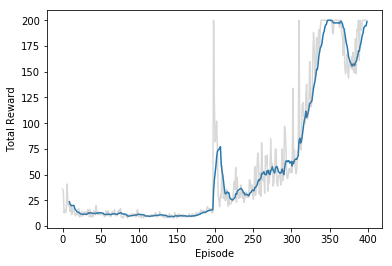

In [13]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [17]:
testQN = QNetwork(name='test', hidden_size=hidden_size)
testQN.build(input_shape=(None, state_size))
testQN.load_weights(log_path)

test_episodes = 10

for ep in range(test_episodes):
    state = env.reset()
    print("initial state:", state)
    R = 0
    while True:
        env.render() 
            
        # Get action from Q-network
        # Hm, the following line could be more elegant ...
        Qs = testQN(np.float32(np.resize(state, (1, state_size))))
        action = np.argmax(Qs)
            
        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)
        R += reward
            
        if done:
            print("number of steps:", R)
            break
        else:
            state = next_state
                

initial state: [ 0.03519044 -0.04169344 -0.01145805 -0.02859688]
number of steps: 200.0
initial state: [ 0.04684447 -0.01760597 -0.04280387 -0.00931263]
number of steps: 200.0
initial state: [-0.04736928 -0.04007403  0.02739608  0.00650904]
number of steps: 200.0
initial state: [ 0.01735609 -0.03771807 -0.00032947  0.0382812 ]
number of steps: 182.0
initial state: [-0.03718574 -0.04106284  0.04537808  0.03193044]
number of steps: 182.0
initial state: [-0.02367494 -0.04973627 -0.03449531 -0.02933311]
number of steps: 200.0
initial state: [-0.03656805  0.00683787  0.03056128 -0.00706383]
number of steps: 195.0
initial state: [-0.00209477 -0.0178964  -0.03209121 -0.02080103]
number of steps: 200.0
initial state: [ 0.04425383 -0.03174616  0.04297296 -0.04320745]
number of steps: 159.0
initial state: [-0.03395295 -0.04571436  0.01957676 -0.04929838]
number of steps: 200.0


In [15]:
env.close()